# <center> Cajamar UniversityHack 2023 

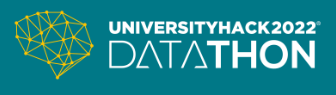

## Equipo: Malbecs
## Fase: I
## Centro: Universidad Complutense de Madrid
### Miembros: Trosman Denis, Stammati Vito, Kumar Sumit.

## <center> Reto Wine Prediction - EDA

## Importación de librerias

In [187]:
#EDA
import os

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import sys

## Lectura de datos

In [193]:

data_path = '../../data'

raw_data_path = os.path.join(data_path,'raw')

def load_data():
    return pd.read_csv(os.path.join(raw_data_path,'UH_2023_TRAIN.txt'), sep='|')
    
    

In [194]:
data = pd.read_csv(os.path.join(raw_data_path,'UH_2023_TRAIN.txt'), sep='|')

In [195]:
data.head()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.00,22215.00
1,14,84318,515,4,660,26,2,0,1,0.00,22215.00
2,14,85579,340,4,520,32,2,0,1,0.00,20978.00
3,14,69671,340,4,520,32,2,0,1,0.00,40722.00
4,14,14001,852,14,NaN,81,1,0,1,0.00,14126.00


In [198]:
def norm_columns(data):
    new_cols = ['campana',
    'id_finca',
    'id_zona',
    'id_estacion',
    'altitud',
    'variedad',
    'modo',
    'tipo',
    'color',
    'superficie',
    'produccion']

    data.columns = new_cols   
    
    return data

data = norm_columns(data)

In [197]:
# data_eto = pd.read_csv(
#     os.path.join(raw_data_path,"DATOS_ETO.TXT"), 
#     sep='|'
# )
# data_eto

## Produccion

In [365]:
# data_test = data[data['campana']==22].copy()
# data_train = data[data['campana']!=22].copy()

In [366]:
data['produccion'].describe()

count     8526.00
mean      9209.19
std      13268.81
min          0.72
25%       1940.00
50%       4620.00
75%      11137.50
max     177520.00
Name: produccion, dtype: float64

<AxesSubplot:xlabel='produccion', ylabel='Count'>

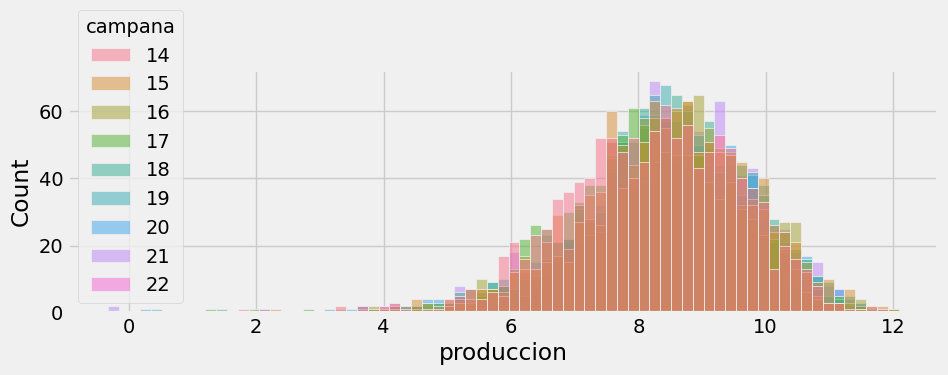

In [31]:
# data['produccion']
plt.figure(figsize=(10,3))
sns.histplot(
    data.assign(
        produccion = lambda df: np.log(df['produccion']),
        campana = lambda df: df['campana'].astype(str)
    ), 
    x='produccion', 
    hue='campana'
)

<AxesSubplot:xlabel='campana'>

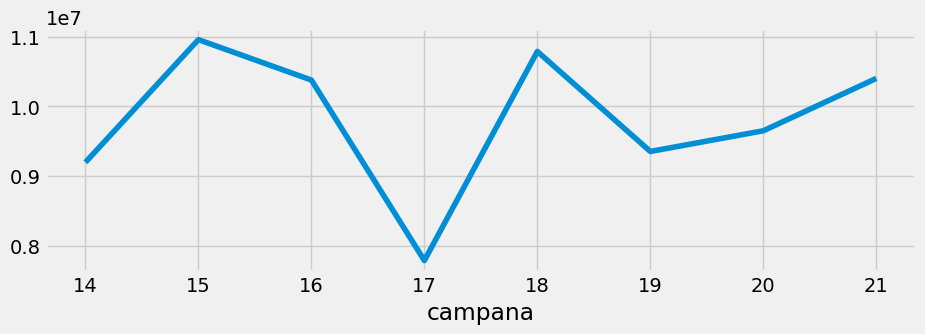

In [30]:
data.groupby('campana')['produccion'].sum()[:-1].plot(figsize=(10,3))

<AxesSubplot:xlabel='produccion', ylabel='Count'>

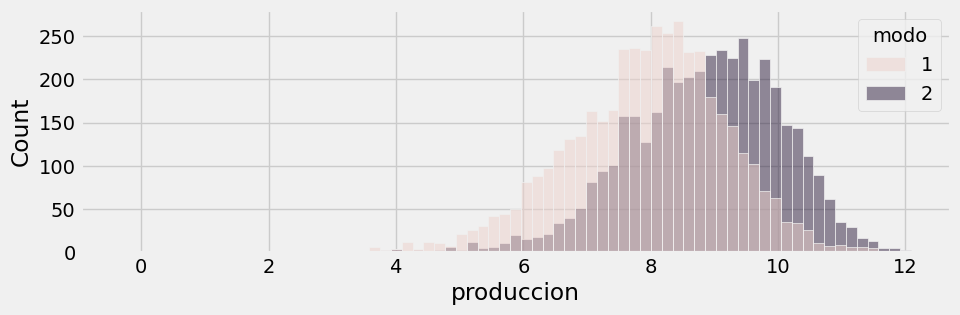

In [40]:
plt.figure(figsize=(10,3))
sns.histplot(
    data.assign(
        produccion = lambda df: np.log(df['produccion']),
        campana = lambda df: df['modo'].astype(str)
    ), 
    x='produccion', 
    hue='modo'
)


<AxesSubplot:xlabel='produccion', ylabel='Count'>

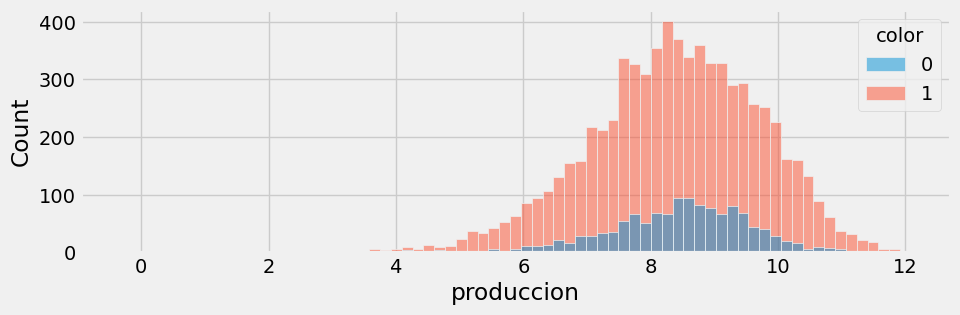

In [42]:
plt.figure(figsize=(10,3))
sns.histplot(
    data.assign(
        produccion = lambda df: np.log(df['produccion']),
        campana = lambda df: df['color'].astype(str)
    ), 
    x='produccion', 
    hue='color'
)


In [54]:
# data['id_zona'].value_counts()[:30]

### Superficie

In [55]:
data['superficie'].describe()

count   9601.00
mean       0.70
std        1.79
min        0.00
25%        0.00
50%        0.00
75%        0.56
max       26.85
Name: superficie, dtype: float64

In [56]:
# Correlacion alta entre produccion y superficie
# pensar como estimar la superficie
data[data['superficie'] > 0 ][['superficie','produccion']].corr()

,superficie,produccion
superficie,1.00,0.74
produccion,0.74,1.00


In [57]:
# incluso por modo hay mas correlacion
data
(
    data
    [(data['superficie'] > 0) & (data['modo']==1)]
    [['superficie','produccion']]
    .corr()
)

,superficie,produccion
superficie,1.00,0.77
produccion,0.77,1.00


In [59]:
fincas_sup_zero = data[data['superficie']==0]['id_finca'].unique()

print("Fincas con superficie = 0: ", len(fincas_sup_zero))

print("Fincas con superficie 0 pero con datos en otra campana: ", data[
    (data['superficie']>0) & (data['id_finca'].isin(fincas_sup_zero))
]['id_finca'].nunique())

Fincas con superficie = 0:  1139
Fincas con superficie 0 pero con datos en otra campana:  832


In [199]:
##### REVISAR!!!!!!!

def process_superficie(data):
    mean_sup_by_finca = (
        data[(data['superficie']>0)]
        .groupby(['id_finca','variedad','modo'])
        .agg({"superficie":"mean"})
    ).reset_index()

    data['superficie_pro'] = data['superficie']

    data.loc[(data['superficie_pro']==0),'superficie_pro'] = (
        data.loc[data['superficie_pro']==0,['id_finca','variedad','modo']].merge(
            mean_sup_by_finca,
            left_on=['id_finca','variedad','modo'],
            right_on=['id_finca','variedad','modo'],
            how='left'
        )['superficie']
    )
    
    return data


data = process_superficie(data)
print('superficies sin dato antes:', data[data['superficie']==0].shape[0])
print("superficies sin dato ahora: ", data[data['superficie_pro'].isnull()].shape[0])

superficies sin dato antes: 6518
superficies sin dato ahora:  1817


In [246]:
# data.groupby(['id_finca','campana']).agg({"superficie":'sum'}).unstack(1)
# data.groupby(['id_finca','campana']).agg({"superficie_pro":'sum'}).unstack(1)

In [244]:

# features nuevas:
# superficie total de la finca ?
# cantidad de variedades en la finca.

tot_sup_camp_finca = (
    data.groupby(['id_finca','campana'])
    .agg({"superficie_pro":'sum'})
    .rename(columns={"superficie_pro":"superficie_total"})
    .reset_index()
)

data.merge(
    tot_sup_camp_finca,
    left_on=['id_finca','campana'],
    right_on=['id_finca','campana'],
    how='left'
)


tot_sup_finca = (
    data.groupby(['id_finca','campana'])
    .agg({"superficie_pro":'sum'})
    .rename(columns={"superficie_pro":"superficie_total"})
    .groupby('id_finca')
    .agg({"superficie_total":"mean"})
    .reset_index()
)


n_variedad_finca = (
    data.groupby(['id_finca','campana'])
    .agg({"variedad":'nunique'})
    .rename(columns={"variedad":"n_variedad"})
)


data.merge(
    n_variedad_finca,
    left_on=['id_finca','campana'],
    right_on=['id_finca','campana'],
    how='left'
)


,campana,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,superficie_pro,altitud_pro,n_variedad
0,14,76953,515,4,660,26,2,0,1,0.00,22215.00,NaN,660.00,1
1,14,84318,515,4,660,26,2,0,1,0.00,22215.00,NaN,660.00,1
2,14,85579,340,4,520,32,2,0,1,0.00,20978.00,NaN,520.00,1
3,14,69671,340,4,520,32,2,0,1,0.00,40722.00,NaN,520.00,1
4,14,14001,852,14,NaN,81,1,0,1,0.00,14126.00,NaN,659.10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9596,22,37461,239,6,700,52,2,0,1,3.68,NaN,3.68,700.00,1
9597,22,58769,239,6,700,32,2,0,1,4.25,NaN,4.25,700.00,2
9598,22,58769,239,6,700,59,2,0,1,4.07,NaN,4.07,700.00,2
9599,22,88928,239,6,700,40,2,0,1,4.57,NaN,4.57,700.00,2


### Fincas

In [253]:
fincas_train = set(data[data['campana']<22]['id_finca'].unique())
fincas_test = set(data[data['campana']==22]['id_finca'].unique())

In [258]:
print("Fincas para entrenamiento: ",len(fincas_train))
print("Fincas para prediccion: ",len(fincas_test))

Fincas para entrenamiento:  1193
Fincas para prediccion:  825


In [270]:
fincas_only_test = fincas_test.difference(fincas_train)
fincas_both = fincas_test.intersection(fincas_train)
print("Fincas solo en prediccion: ",len(fincas_only_test))
print("Fincas en prediccion y entrenamiento: ", len(fincas_both))

Fincas solo en prediccion:  38
Fincas en prediccion y entrenamiento:  787


In [267]:
# fincas_only_test

In [202]:
# # estimamos la superficie con un arbol
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import cross_validate
# SEED = 42

# m = DecisionTreeRegressor(
#     criterion='squared_error',
#     splitter='best',
#     max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     min_weight_fraction_leaf=0.0,
#     max_features=None,
#     random_state=SEED,
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     ccp_alpha=0.0
# )

# m = make_pipeline(
#     OneHotEncoder(handle_unknown='ignore'),
#     DecisionTreeRegressor(random_state=SEED)
# )

# data_sup = data[
#     (data['superficie']>0)
#     &
#     (data['superficie_pro'].notnull())
# ].drop(columns=['produccion','superficie_pro'])

# features = ['id_finca','id_zona','id_estacion','variedad','modo']

# X = data_sup[features]
# y = data_sup['superficie']


# res = cross_validate(
#     m,
#     X,
#     y,
#     cv=10,
#     scoring=['neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
    
# )
# m.fit(X,y)
# res
# print(np.mean(res['test_neg_mean_absolute_percentage_error']))
# print(np.mean(res['test_neg_root_mean_squared_error']))



In [203]:
# # estimacion
# # data.loc[data['superficie']==0,'superficie_pred'] = m.predict(
# #     data[data['superficie']==0][features]
# # )

# data['superficie_pred'] = np.nan

# data.loc[data['superficie_pro'].notnull(),'superficie_pred'] = m.predict(
#     data[data['superficie_pro'].notnull()][features]
# )

In [204]:
# data[
#     (data['superficie']>0) & (data['id_finca'].isin(fincas_sup_zero))
# ]['id_finca'].unique()[:10]

In [205]:
# # data[data['id_finca']==4024].sort_values(['campana','variedad'])

# data[data['superficie_pred'].isnull()].shape[0]

In [206]:
# data.dropna(subset='superficie_pro')[data['superficie_pro']!=data['superficie_pred']]

In [207]:
# conclusion: da casi igual hacerlo con un arbol o a mano.

In [208]:
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.experimental import enable_iterative_imputer

# from sklearn.impute import KNNImputer, SimpleImputer,IterativeImputer
# from sklearn.model_selection import train_test_split, cross_validate
# from sklearn.feature_selection import SelectFromModel
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# import sklearn

# sklearn.metrics.get_scorer_names()
# df = df.sort_values('campana')

# df_modelo = data[data['superficie_pro'].notnull()].sort_values('campana')
# df_modelo = data[data['superficie']>0].sort_values('campana')

In [209]:

# df_tr = df_modelo[df_modelo['produccion'].notnull()]

# X = df_tr[[
#     'superficie_pro',
#     'altitud_pro',
#     'modo',
#     'color',
#     "variedad",
#     "id_estacion",
#     "campana",
#     "id_zona",
#     "tipo"
# ]]
# y = df_tr['produccion']



# # test_size=int(0.2*X.shape[0])
# test_index = X[df_tr['campana']==21].index
# train_index = X[df_tr['campana']!=21].index

# # train_test_split(X, y, test_size=100, shuffle=False)
# # X_train, X_test, y_train, y_test = X[:-test_size],X[-test_size:], y[:-test_size],y[-test_size:]
# X_train, X_test, y_train, y_test = X.loc[train_index],X.loc[test_index], y[train_index],y[test_size]


# print(X_train.shape)
# print(X_test.shape)

# m = make_pipeline(
# #     KNNImputer(n_neighbors=10),
#     IterativeImputer(),
# #     StandardScaler(),
# #     LinearRegression()
#     RandomForestRegressor(random_state=32)
# )

# m.fit(X_train, y_train)

# y_pred = m.predict(X_test)

# print(f"{mean_absolute_percentage_error(y_pred=y_pred, y_true=y_test)}")
# print(f"{np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))}")

# # cross_validate(
# #     estimator=m,
# #     X=X,
# #     y=y,
# #     scoring=['neg_mean_absolute_percentage_error','neg_root_mean_squared_error']
# # )

### Altura

In [210]:
def process_altitud(data):
    data['altitud_pro'] = data['altitud'].str.split("-",expand=True).fillna(0).astype(float).apply(
        lambda row: (row[0]+row[1])/2 if (row[0] > 0 and row[1] > 0) else row[0], axis=1
    )
    data.loc[data['altitud_pro']==0,'altitud_pro'] = np.NaN
    return data

def impute_altitud(data):
    data['altitud_pro']  = (
        data.groupby("id_estacion")['altitud_pro'].transform(lambda x: x.fillna(x.mean()))  
    )
    return data

data = process_altitud(data)
data = impute_altitud(data)

In [211]:
data[['altitud_pro','produccion']].dropna().corr()

,altitud_pro,produccion
altitud_pro,1.00,0.15
produccion,0.15,1.00


In [212]:
# cada zona tiene una altitud -> imputar con eso
(
    data
    [data['altitud_pro'].notnull()]
    .groupby("id_zona")
    .agg({"altitud_pro":"nunique"})
).max()

altitud_pro    2
dtype: int64

In [213]:
# cada finca pertenece a una unica zona
data.groupby('id_finca').agg({"id_zona":"nunique"}).max()

id_zona    1
dtype: int64

In [214]:
data.isnull().sum()

campana              0
id_finca             0
id_zona              0
id_estacion          0
altitud             54
variedad             0
modo                 0
tipo                 0
color                0
superficie           0
produccion        1075
superficie_pro    1817
altitud_pro          0
dtype: int64

In [219]:
# data['variedad'].value_counts().plot(kind='barh')

In [218]:
# cada variedad tiene un unico color
data[['variedad','color']].drop_duplicates().sort_values('variedad')
data.groupby('variedad')[['color']].nunique()

,color
variedad,
4,1
8,1
9,1
10,1
15,1
17,1
23,1
26,1
32,1


Caracteristicas principales

In [7]:
print(f'Número de filas: {data.shape[0]}, Número de columnas:{data.shape[1]}')
print(f'\nCantidad de duplicados: {data.duplicated().sum()}\n')
print('-------- Tipos de columnas --------')
print(data.dtypes)
print('\n -------- Cantidad de nulos --------')
data.isna().sum()

Número de filas: 9601, Número de columnas:11

Cantidad de duplicados: 0

-------- Tipos de columnas --------
CAMPAÑA          int64
ID_FINCA         int64
ID_ZONA          int64
ID_ESTACION      int64
ALTITUD         object
VARIEDAD         int64
MODO             int64
TIPO             int64
COLOR            int64
SUPERFICIE     float64
PRODUCCION     float64
dtype: object

 -------- Cantidad de nulos --------


CAMPAÑA           0
ID_FINCA          0
ID_ZONA           0
ID_ESTACION       0
ALTITUD          54
VARIEDAD          0
MODO              0
TIPO              0
COLOR             0
SUPERFICIE        0
PRODUCCION     1075
dtype: int64

Vemos distribuciones y si hay valores mayoritarios

In [8]:
def valores_unicos(df,columna):
    data_frame = pd.DataFrame(df[columna].value_counts())
    data_frame['share']=data_frame[columna]/sum(data_frame[columna])*100 
    return data_frame

#Funcion para mostrar DataFrames lado por lado
#fuente: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

from IPython.display import display_html
from itertools import chain,cycle

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [10]:
for col in data.columns:
    display_side_by_side(valores_unicos(data,col).head(),
                         titles = [col])

,CAMPAÑA,share
14,1148,11.96
15,1116,11.62
16,1079,11.24
22,1075,11.20
18,1061,11.05


,ID_FINCA,share
4024,59,0.61
49636,54,0.56
48827,47,0.49
84174,46,0.48
61177,36,0.37


,ID_ZONA,share
441,703,7.32
272,419,4.36
134,406,4.23
464,378,3.94
510,283,2.95


,ID_ESTACION,share
12,2060,21.46
5,1155,12.03
7,1113,11.59
16,1087,11.32
15,956,9.96


,ALTITUD,share
455-470,703,7.36
650-660,680,7.12
455-465,431,4.51
630-640,430,4.50
600-670,419,4.39


,VARIEDAD,share
59,2770,28.85
17,2167,22.57
32,974,10.14
52,611,6.36
81,568,5.92


,MODO,share
2,4891,50.94
1,4710,49.06


,TIPO,share
0,9483,98.77
1,118,1.23


,COLOR,share
1,8097,84.33
0,1504,15.67


,SUPERFICIE,share
0.00,6518,67.89
1.85,14,0.15
2.11,12,0.12
0.78,12,0.12
0.57,11,0.11


,PRODUCCION,share
2950.00,10,0.12
2260.00,10,0.12
1970.00,9,0.11
2670.00,9,0.11
3520.00,9,0.11


Unique values

In [11]:
data.nunique(axis=0)

CAMPAÑA           9
ID_FINCA       1231
ID_ZONA         125
ID_ESTACION      20
ALTITUD          84
VARIEDAD         25
MODO              2
TIPO              2
COLOR             2
SUPERFICIE     1212
PRODUCCION     6287
dtype: int64

Distribuciones y descripción general

In [12]:
#Númericas
data.describe()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
count,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,8526.00
mean,17.94,50818.24,498.50,12.16,45.49,1.51,0.01,0.84,0.70,9209.19
std,2.61,29016.57,261.43,4.76,23.81,0.50,0.11,0.36,1.79,13268.81
min,14.00,200.00,7.00,0.00,4.00,1.00,0.00,0.00,0.00,0.72
25%,16.00,25104.00,284.00,7.00,17.00,1.00,0.00,1.00,0.00,1940.00
50%,18.00,50946.00,464.00,12.00,52.00,2.00,0.00,1.00,0.00,4620.00
75%,20.00,76361.00,726.00,16.00,59.00,2.00,0.00,1.00,0.56,11137.50
max,22.00,99793.00,990.00,19.00,94.00,2.00,1.00,1.00,26.85,177520.00


In [13]:
#Resto
data.describe(include='O')

,ALTITUD
count,9547
unique,84
top,455-470
freq,703


Correlaciones

In [14]:
def generate_heatmap_graph(corr, chart_title, mask_uppertri=False ):
    
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = mask_uppertri
    fig,ax = plt.subplots(figsize=(12,12))
    ax.set_facecolor('white')
    sns.heatmap(corr
                , mask = mask
                , square = True
                , annot = True
                , annot_kws={'size': 10.5, 'weight' : 'bold'}
                , cmap=plt.get_cmap("YlOrBr")
                , linewidths=.1)
    plt.title(chart_title, fontsize=14)

    plt.show()

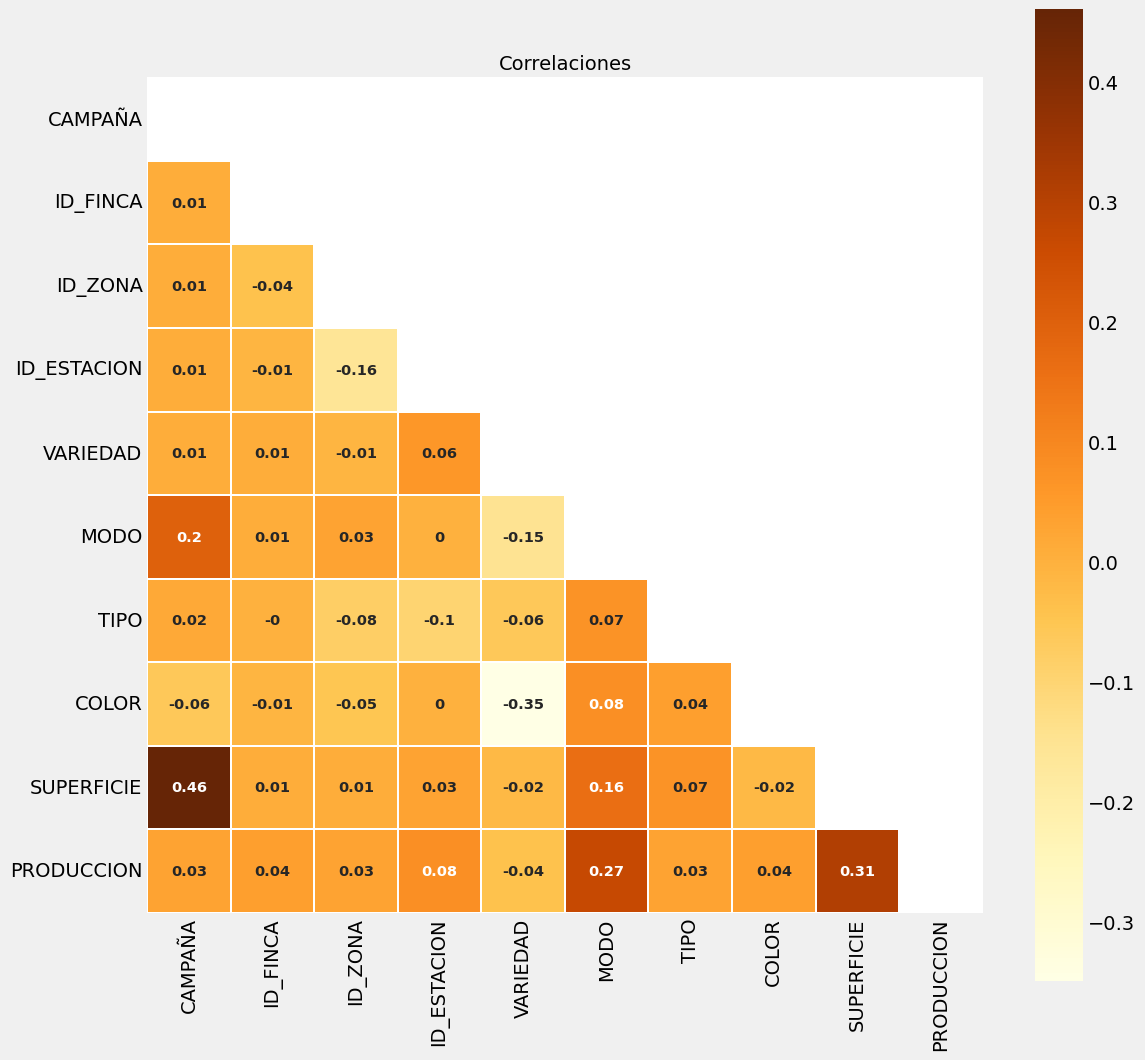

In [15]:
num_cols =  data.select_dtypes([np.number]).columns

df_num = data[num_cols]

cor_mat = round(df_num.corr(),2)

generate_heatmap_graph(cor_mat
                       ,chart_title = 'Correlaciones'
                       ,mask_uppertri = True)

## Visualizacion

In [18]:
label = "PRODUCCION"

px.line(data_frame =  data, x='CAMPAÑA', y=label,title = "Produccion" )

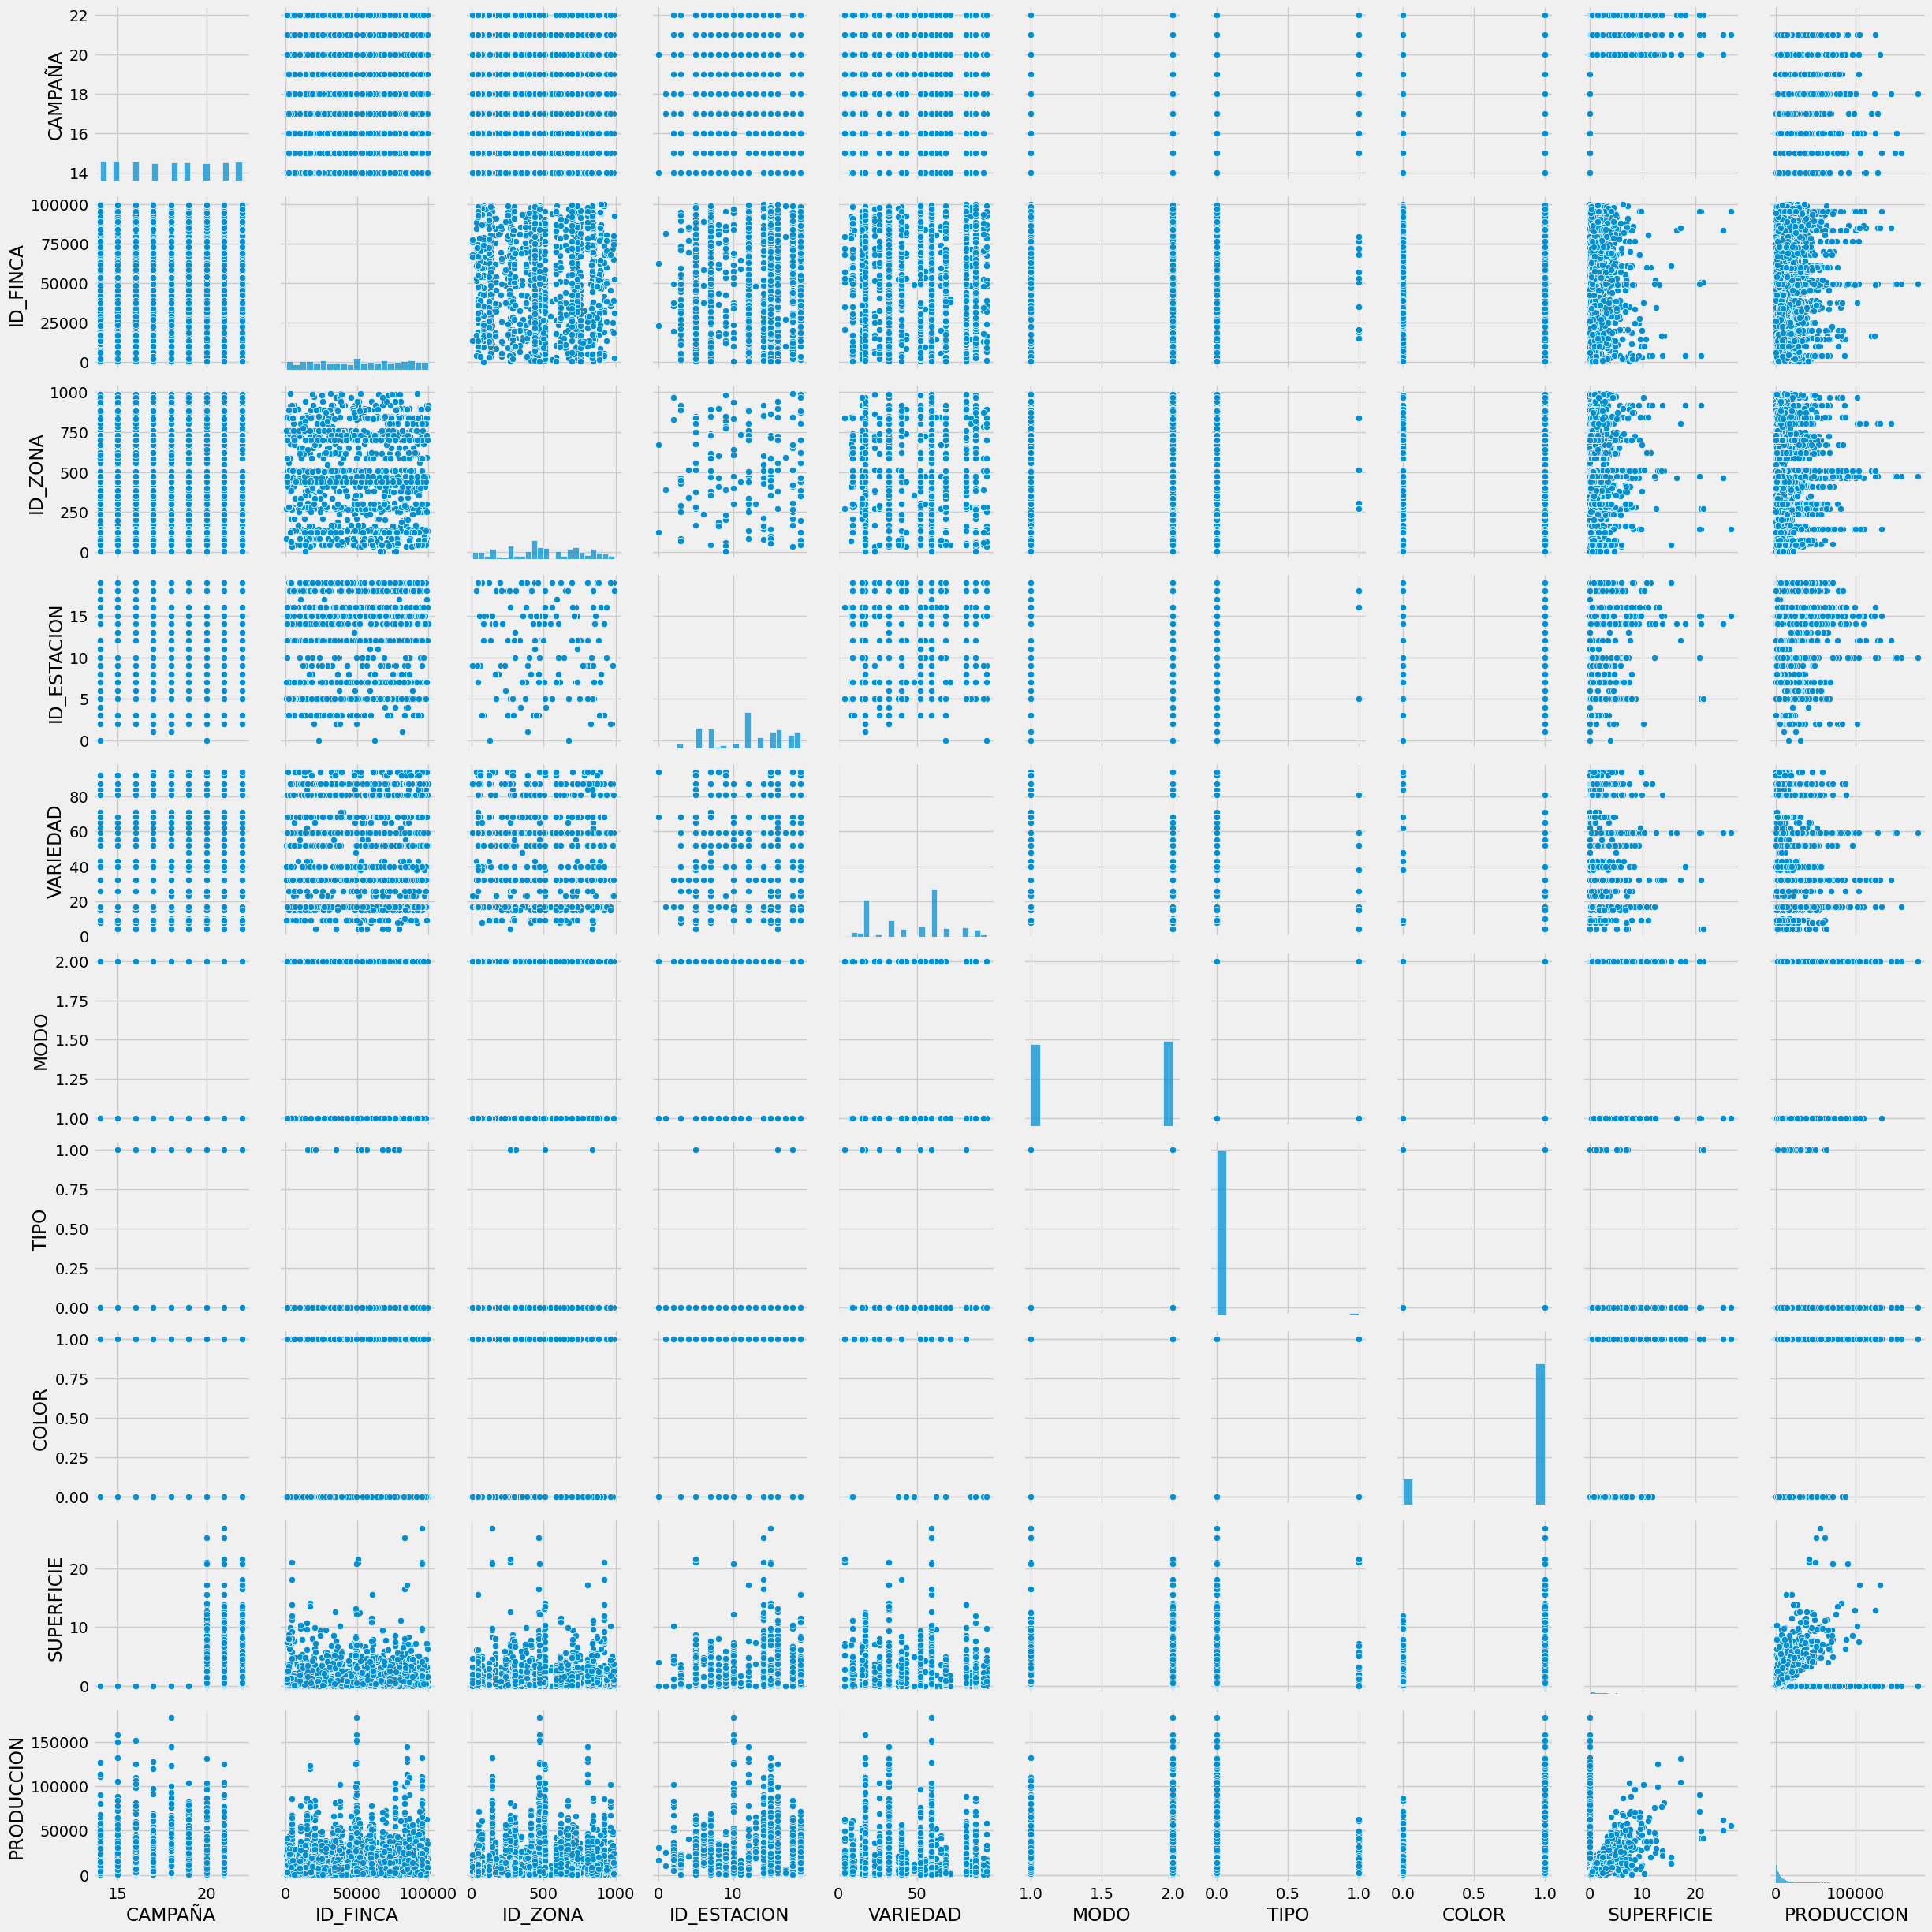

In [19]:
sns.pairplot(data)

Histogramas

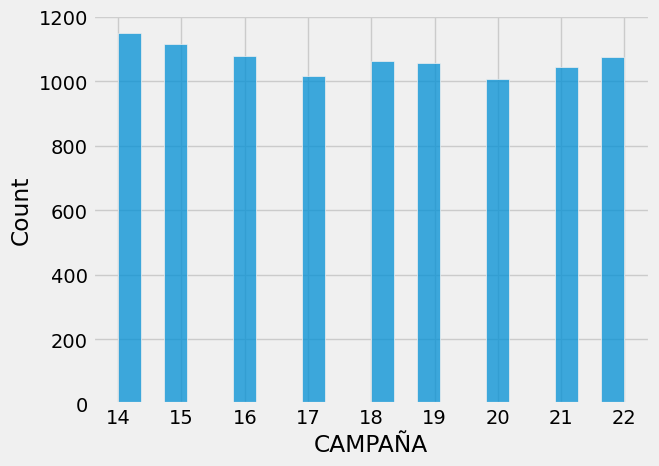

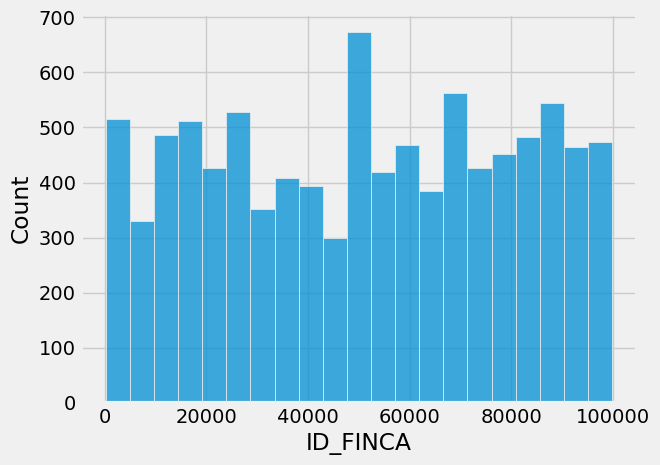

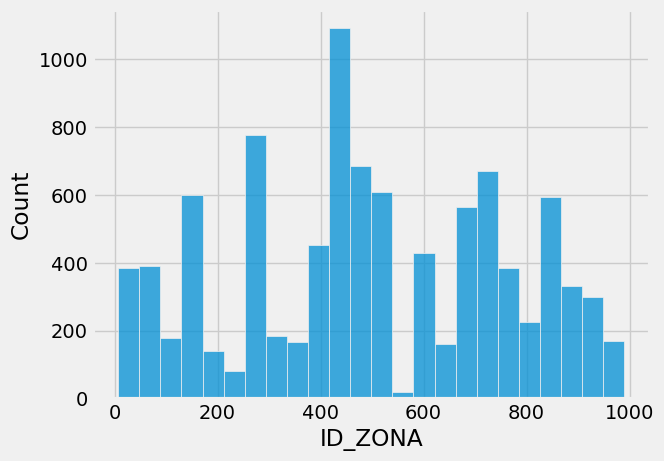

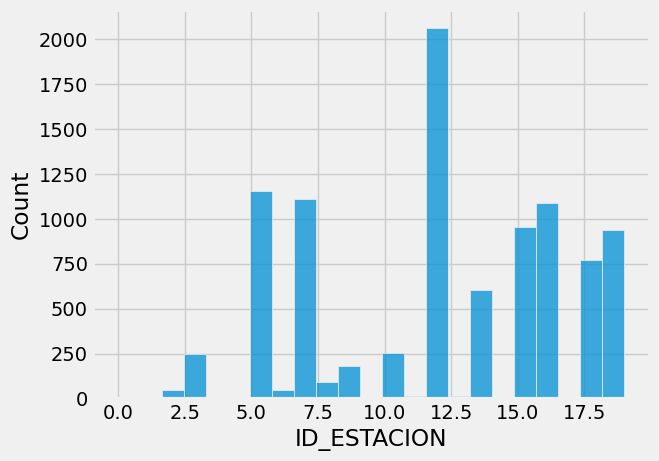

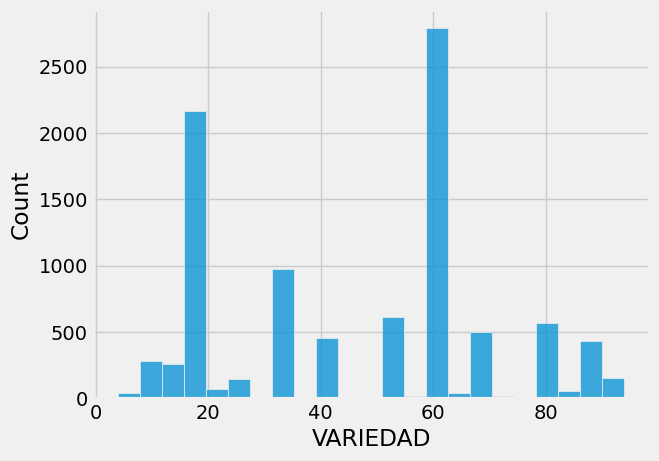

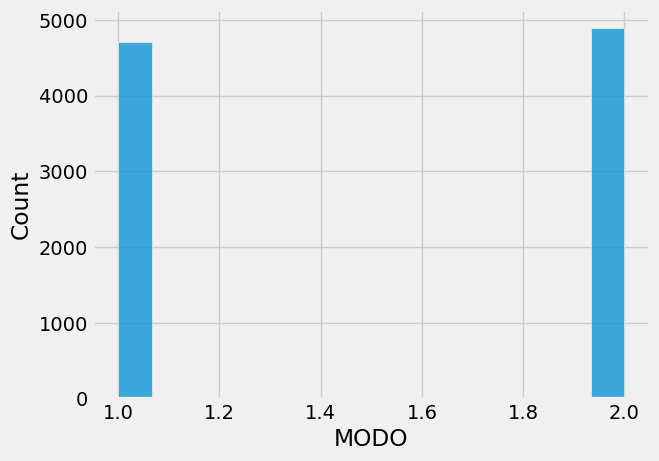

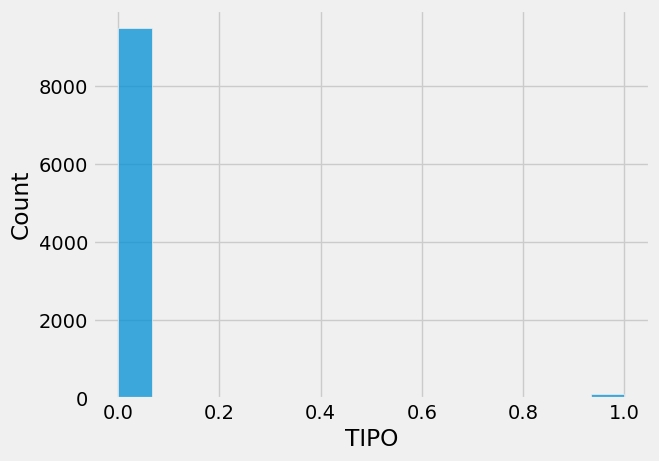

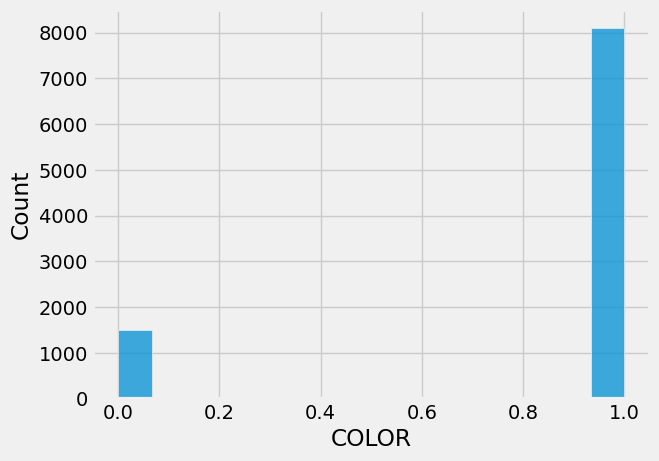

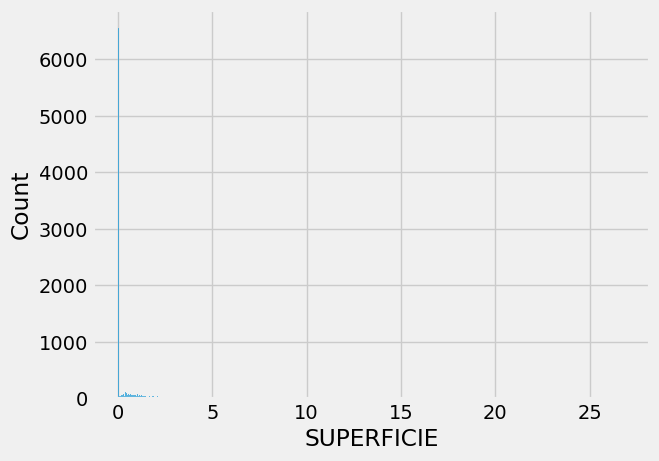

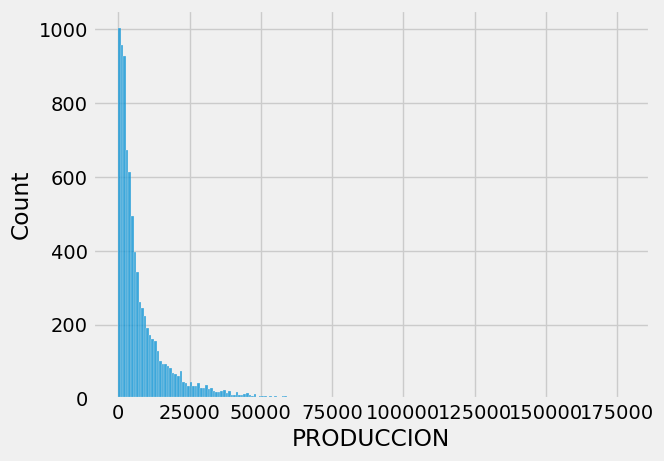

In [20]:
for col in num_cols:
    sns.histplot(data=data,x=col)
    plt.show()